# What corrections would we give to just FPs?

I expected that our raw fingerprints, such as the hbond scores, would not be able to distinguish native from decoy poses past what the glide score already predicts. This makes computing the correction factors for the raw fingerprints a good null test i.e. if all of the math is right the corrections should be small. For the most part, this is what we observe.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
data = {}
with open('../../combind_data/bpp_outputs/fps.csv') as fp:
    fp.readline()
    for line in fp:
        try:
            (protein, struct, ligand, rank, gscore, emodel,
             rmsd, finger) = line.strip().split('\t')
            if protein not in data: data[protein] = {}
            if ligand not in data[protein]: data[protein][ligand] = {}
            finger = {(int(interaction), residue): float(score)
                      for interaction, residue, score in \
                      map(lambda x: x.split(','), finger.split(';'))}
            gscore, emodel, rmsd = float(gscore), float(emodel), float(rmsd)
            rank = int(rank)
            data[protein][ligand][rank] = (gscore, emodel, rmsd, finger)
        except:
            pass
for protein, ligand in data.items():
    print protein, len(ligand)

P00489 20
5HT2B 2
PLK1 12
Q16539 19
MGLUR5 5
ERA 19
M3 2
P07900 20
GLUT1 3
P18031 20
P56817 20
O60885 17
MEK1 20
JAK2 20
P00742 20
DTRANSP 9
SIGMA1 2
P00734 20
P00760 20
B2AR 8
GCR 18
P24941 13
B1AR 12
VITD 20
A2AR 18
SMO 7
P03951 14
P00749 20
Q9Y233 20
CHK1 20
TRPV1 2
CDK2 20
AR 11
BRAF 19
MR 13
STRANSP 5


In [3]:
features = {
    'hbond_donor':[2],
    'hbond_acceptor':[3],
    #'sb1':[0],
    'sb2':[1],
    #'sb3':[4],
    'pipi':[6],
    'picat':[7,8],
    'contact':[11]
}

# Probability of correctness given glide score

In theory, the log probability correct should be proportional to exp(-G), but in practice this isn't quite true. We can instead compute the emperical relationship between glide score and correctness by using a kernel-based local averaging approach.

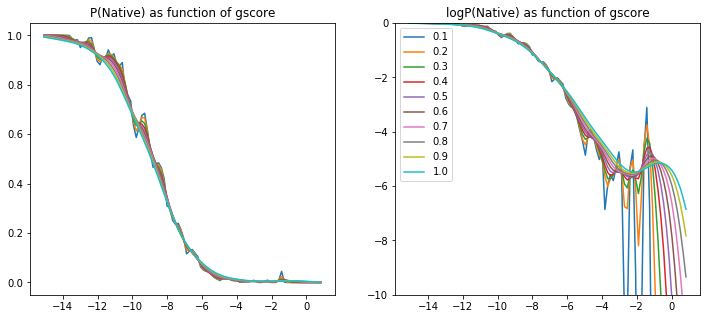

In [4]:
def gauss(mean, sd, x):
    mean, sd = float(mean), float(sd)
    return np.exp(-((x - mean)/sd)**2)

def kernel_ratio(scores, labels, sd, bins = 100):
    x = np.linspace(scores.min(), scores.max(), bins)
    ratio = []
    for _x in x:
        weights = np.array([gauss(_x, sd, score) for score in scores])
        ratio += [(labels*weights).sum() / weights.sum()]
    return x, np.array(ratio)

gscores = np.array([pose[0]
                    for protein, ligands in data.items()
                    for ligand, poses in ligands.items()
                    for rank, pose in poses.items()])
natives = np.array([pose[2] <= 2
                    for protein, ligands in data.items()
                    for ligand, poses in ligands.items()
                    for rank, pose in poses.items()])

# Choose Standard Dev.
f, ax = plt.subplots(1, 2, figsize = (12, 5))
for sd in np.linspace(.1, 1, 10):
    p_x, p_y = kernel_ratio(gscores, natives, sd)
    ax[0].set_title('P(Native) as function of gscore')
    ax[0].plot(p_x, p_y, label = sd)
    
    ax[1].set_title('logP(Native) as function of gscore')
    ax[1].plot(p_x, np.log(p_y), label = sd)
    ax[1].set_ylim(-10, 0)
ax[1].legend(loc='best')
plt.show()

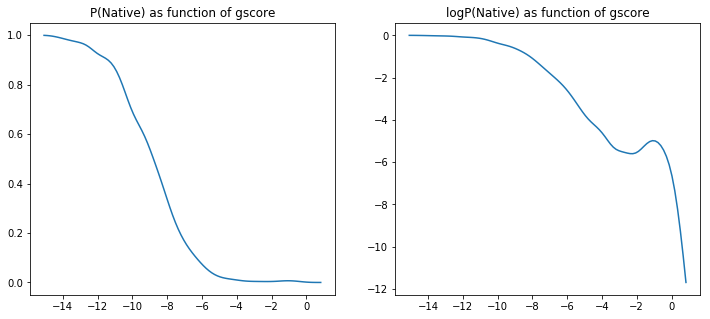

In [5]:
# Standard dev. to be used below.
sd = 0.7
f, ax = plt.subplots(1, 2, figsize = (12, 5))
p_x, p_y = kernel_ratio(gscores, natives, sd)
ax[0].set_title('P(Native) as function of gscore')
ax[0].plot(p_x, p_y)
    
ax[1].set_title('logP(Native) as function of gscore')
ax[1].plot(p_x, np.log(p_y))
plt.show()


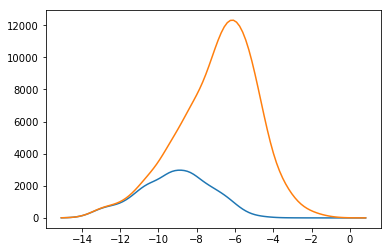

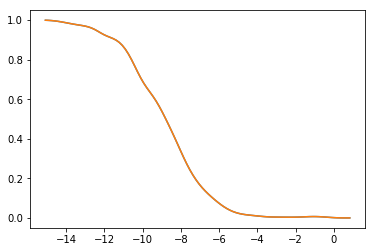

In [6]:
# Just for fun.
sd = 0.7
x = np.linspace(gscores.min(), gscores.max(), 100)
p_x_given_native = []
p_x_given_decoy = []
for _x in x:
    weights = np.array([gauss(_x, sd, gscore) for gscore in gscores])
    p_x_given_native += [(natives*weights).sum()]
    p_x_given_decoy  += [weights.sum()]
p_x_given_native, p_x_given_decoy = np.array(p_x_given_native), np.array(p_x_given_decoy)

plt.plot(x, p_x_given_native)
plt.plot(x, p_x_given_decoy)
plt.show()

plt.plot(x, p_x_given_native / p_x_given_decoy, label = 'Two-Step')
plt.plot(p_x, p_y, label = 'One-Step')
plt.show()

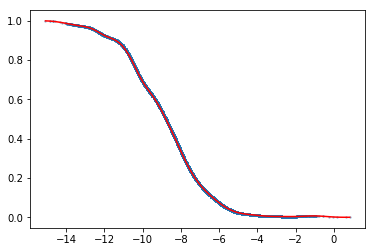

In [7]:
def interpolate(val, x, y):
    """
    Linearly interpolate f(x) = y for value val.
    """
    idx = 0
    while val > x[idx]:
        idx += 1
    if idx == x.shape[0] - 1:
        return y[-1]
    else:
        d = x[idx+1] - x[idx]
        return (  y[idx]   * (x[idx+1] - val)/d
                + y[idx+1] * (val - x[idx])/d)
    
p = [interpolate(gscore, p_x, p_y) for gscore in gscores]
plt.scatter(gscores, p, alpha = 0.4, s = 2)
plt.plot(p_x, p_y, c = 'r')
plt.show()

# Compute correction factors for each interaction type

- the hypothesis is that these corrections should be very small, as I don't expect that they will have anything to add over what glide already factors in.

0.0951586219984


/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: divide by zero encountered in log


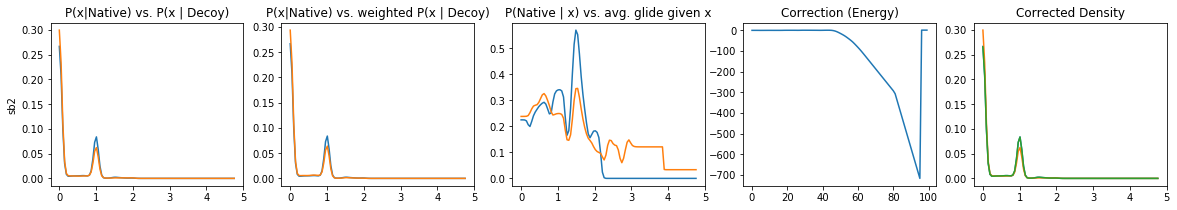

0.790610493306 0.79757281426
0.852358217593 0.855222734255
0.883399756352 0.887358738079


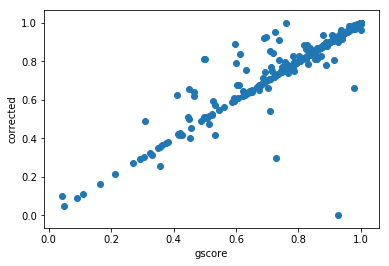

0.14839538545


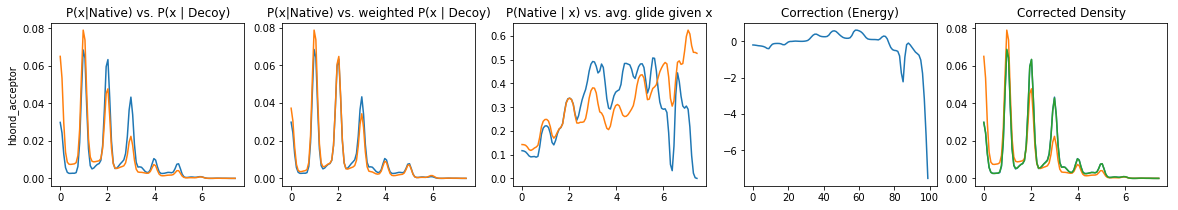

0.790610493306 0.791210250468
0.852358217593 0.832373026035
0.883399756352 0.890216268574


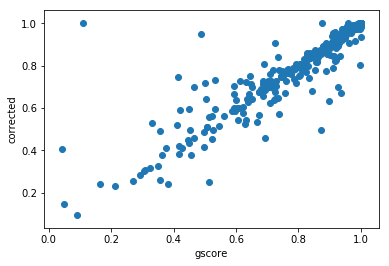

6.37628213327


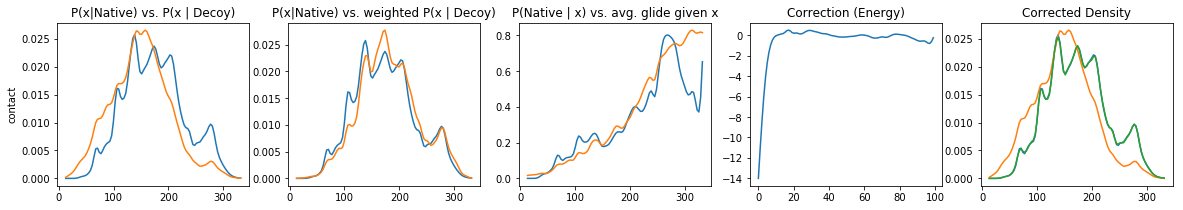

0.790610493306 0.78552069277
0.852358217593 0.846341690582
0.883399756352 0.892248954344


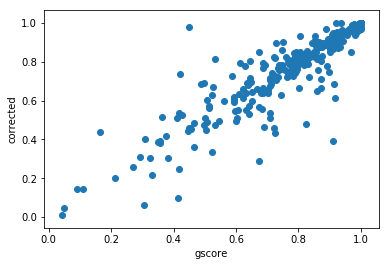

0.197169311423


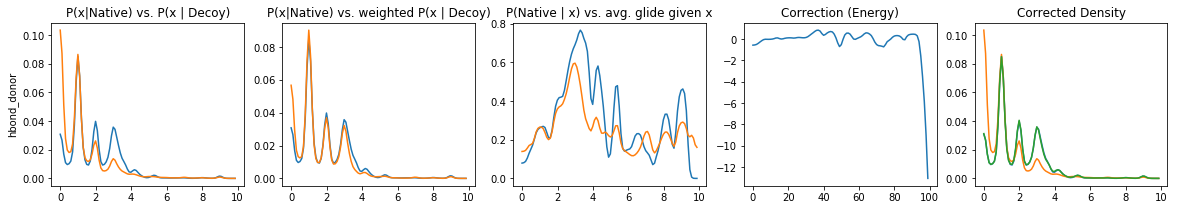

0.790610493306 0.797953661281
0.852358217593 0.868625879615
0.883399756352 0.899099558216


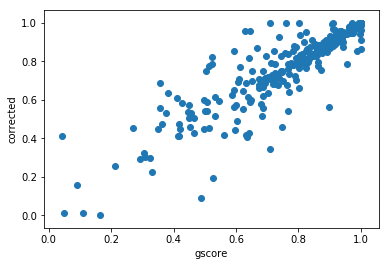

0.06


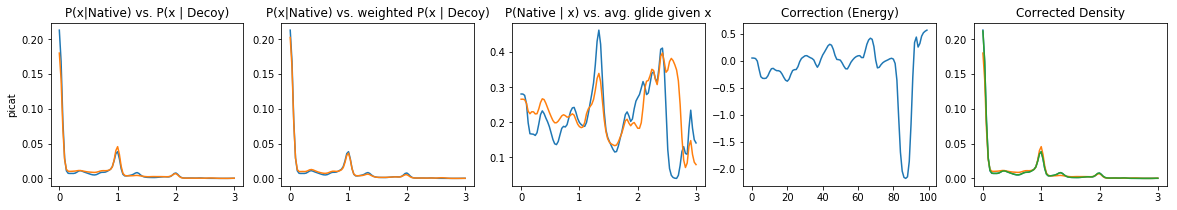

0.790610493306 0.790234711195
0.852358217593 0.842157591703
0.883399756352 0.887218251786


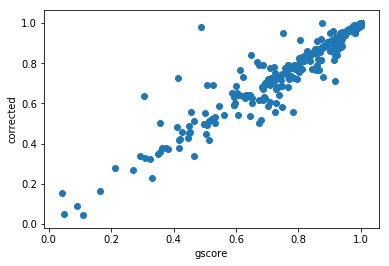

0.0689668013056


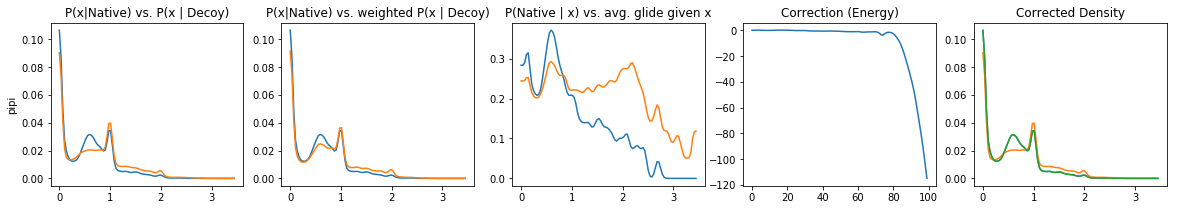

0.790610493306 0.775610004473
0.852358217593 0.837301587302
0.883399756352 0.894627753632


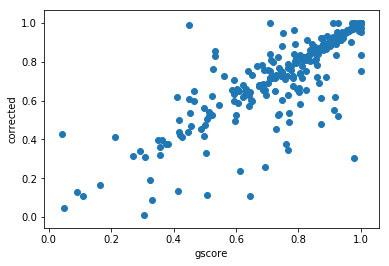

In [8]:
# Continuous Case

from sklearn.metrics import roc_auc_score

for feature, codes in features.items():
    scores, natives, gscores = [], [], []
    for protein, ligands in data.items():
        for ligand, poses in ligands.items():
            for rank, pose in poses.items():
                natives += [pose[2] <= 2]
                scores += [sum([score
                                 for (code, residue), score in pose[-1].items()
                                 if code in codes])]
                gscores += [interpolate(pose[0], p_x, p_y)]
    scores, natives, gscores = np.array(scores), np.array(natives), np.array(gscores)

    sd = (scores.max() - scores.min()) / 50.0
    print sd
    
    x = np.linspace(scores.min(), scores.max(), 100)
    f_native_x, f_decoy_x, f_decoy_x_weighted = [], [], []
    for _x in x:
        weights = np.array([gauss(_x, sd, score) for score in scores])
        f_native_x += [(natives*weights).sum()]
        f_decoy_x  += [weights.sum()]
        f_decoy_x_weighted += [(gscores*weights).sum()]
    f_native_x = np.array(f_native_x)
    f_decoy_x = np.array(f_decoy_x)
    f_decoy_x_weighted = np.array(f_decoy_x_weighted)
    
    ###########################################################
    
    f, ax = plt.subplots(1, 5, figsize = (20, 3))
    ax[0].set_title('P(x|Native) vs. P(x | Decoy)')
    ax[0].plot(x, f_native_x / np.sum(f_native_x))
    ax[0].plot(x, f_decoy_x / np.sum(f_decoy_x))
    
    ax[1].set_title('P(x|Native) vs. weighted P(x | Decoy)')
    ax[1].plot(x, f_native_x / np.sum(f_native_x))
    ax[1].plot(x, f_decoy_x_weighted / np.sum(f_decoy_x_weighted))
    
    ax[2].set_title('P(Native | x) vs. avg. glide given x')
    ax[2].plot(x, f_native_x / f_decoy_x)
    ax[2].plot(x, f_decoy_x_weighted / f_decoy_x)
    
    # Either way you get an identical result!!
    ax[3].set_title('Correction (Energy)')
    C = np.log(f_native_x) - np.log(f_decoy_x_weighted)
    C[np.isnan(C)] = 1
    C[np.isinf(C)] = 1
    ax[3].plot(C)
    
    #################################################################
    # Repeat including corrections and see how well new scores work
    ax[4].set_title('Corrected Density')
    scores, natives, gscores, corrected = [], [], [], []
    g_auc = []
    c_auc = []
    for protein, ligands in data.items():
        for ligand, poses in ligands.items():
            for rank, pose in poses.items():
                natives += [pose[2] <= 2]
                scores += [sum([score
                               for (code, residue), score in pose[-1].items()
                               if code in codes])]
                gscores += [interpolate(pose[0], p_x, p_y)]
                corrected += [interpolate(pose[0], p_x, p_y)
                              *np.exp(interpolate(scores[-1], x, C))]
            if np.mean(natives[-rank:]) != 1 and np.mean(natives[-rank:]) != 0:
                g_auc += [roc_auc_score(natives[-rank:], gscores[-rank:])]
                c_auc += [roc_auc_score(natives[-rank:], corrected[-rank:])]

    
    scores, natives, corrected = np.array(scores), np.array(natives), np.array(corrected)
    f_native_x, f_decoy_x, f_decoy_x_weighted = [], [], []
    x = np.linspace(scores.min(), scores.max(), 100)
    for _x in x:
        weights = np.array([gauss(_x, sd, score) for score in scores])
        f_native_x += [(natives*weights).sum()]
        f_decoy_x  += [weights.sum()]
        f_decoy_x_weighted += [(corrected*weights).sum()]
    f_native_x = np.array(f_native_x)
    f_decoy_x = np.array(f_decoy_x)
    f_decoy_x_weighted = np.array(f_decoy_x_weighted)
    
    ax[4].plot(x, f_native_x / np.sum(f_native_x))
    ax[4].plot(x, f_decoy_x / np.sum(f_decoy_x))
    ax[4].plot(x, f_decoy_x_weighted / np.sum(f_decoy_x_weighted))
    
    ax[0].set_ylabel(feature)
    plt.show()
    
    plt.scatter(g_auc, c_auc)
    print np.mean(g_auc), np.mean(c_auc)
    print np.median(g_auc), np.median(c_auc)
    print roc_auc_score(natives, gscores), roc_auc_score(natives, corrected)
    plt.xlabel('gscore')
    plt.ylabel('corrected')
    plt.show()